In [ ]:
try:
  # We must install required packages if we are in Google Colab
  import google.colab
  %pip install roboticstoolbox-python>=1.0.2
except:
  # We are not in Google Colab
  # Apply custom style to notebook
  from IPython.core.display import HTML
  import pathlib
  styles_path = pathlib.Path(pathlib.Path().absolute(), "style", "style.css")
  styles = open(styles_path, "r").read()
  HTML(f"<style>{styles}</style>")

# 1.0 Position Kinematics


## Table of Contents

> #### 1.1 Introduction
> #### 1.2 The Elementary Transform Sequence
> #### 1.3 The Elementary Transforms
> #### 1.4 The Homogenous Transform Matrix
> #### 1.5 Examples

## 1.1 Introduction
----
Let us first begin by introducing the topic of Forward Kinematics. For this project, we were tasked with creating a pick and place controller for a 7 degree of freedom (DOF) robotic arm. This means that, similar to a human arm, the robot arm can move and twist in 7 different ways.

The first objective for forward kinematics was to develop a mathematical method which would allow us to deal with all of the arms joints simultaneously rather than individually. This would dramatically reduce the number of equations needed to determine the end-effector's position relative to the stationary base frame.

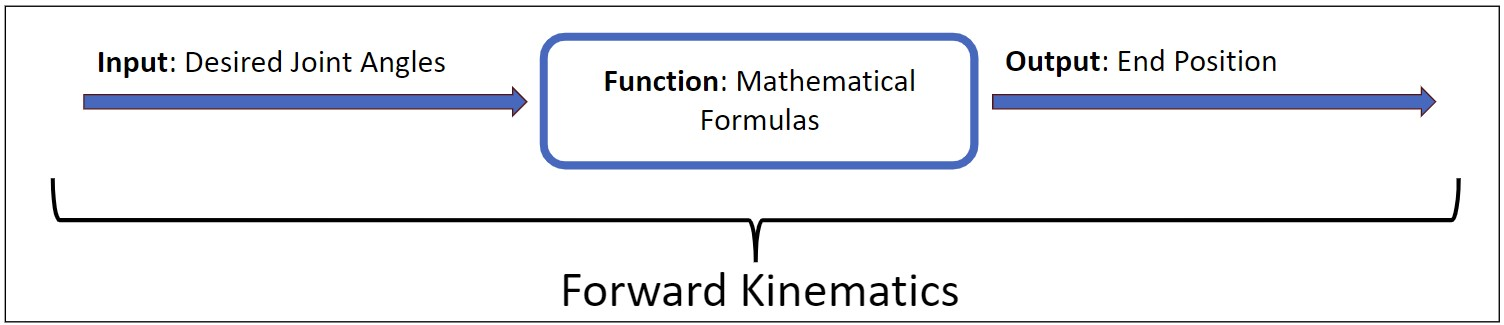

To relate this concept back to your arm, if you know how much you rotate your shoulder joint, elbow joint, wrist joint, and all of your finger joints, you will therefore be able to know where your finger will be. Our goal for the forward kinematics was to represent this, in terms of the arm, in a mathematical manner.

We have now discussed what Forward Kinematics is, but we have not yet discussed what First Order is referring to. First Order is simply referring to displacement of the arm, this means that we will not focus on the velocity nor the acceleration in this first section.

Combining all of this, we can now understand what the first topic is all about. The Forward and First Order Kinematics is referring to the placing of objects and looks specifically at displacements.

Before diving into the mathematics, there are some important things to get out of the way.

Firstly, each joint has it's own coordinate system. We designed our coordinate systems in such a way that the joints will always rotate about the z-axis. This means that the x-axis, y-axis, and z-axis for one joint will not be the same as another.

Secondly, we will mention "translations" often, so it is important to know what exactly we are talking about. Translations in this case don't refer to the joints being translational joints but rather the distance from one joint's coordinate system to another joint's coordinate system. These translations are due to the joints being offset from one another.

Thirdly, we will not dive deep into the derivations of these mathematical equations. We are primarily focused on how these equations can be used for pick and place tasks and not the origins of these equations.

Lastly, we have presented an image of the robotic arm to help visualise the type of robotic arm utilised. The image shows all the translations/offsets from one joint to the next and the coordinate system for each joint.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This diagram below can be used to help visualise what the arm looks like. In the bottom right hand corner, a coordinate system can be seen. As you can see, the coordinate system changes for every actuator, this is because we want the actuator to always rotate about the z-axis. The numbers seen on the far left hand side show all of the vertical offsets. The numbers seen near the middle section of the image show the horizontal offsets. It should be noted that there are no offsets in the x direction. The base frame is the frame of reference for the base, the base in our case is the table that the arm is mounted to. There is also no end-effector shown, but it would be located above  the interface module frame.

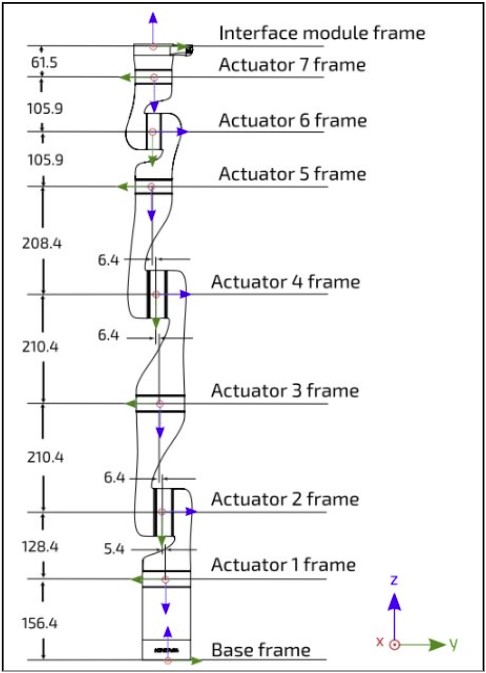 <br>
**Figure 2: Schematic of the 7DOF Kinova Robot Arm and the Joint Offsets [1]**


In [ ]:
# We will begin by importing some useful functions
# Numpy allows us to use linear algebra functions such as vectors, arrays, and matrices
import numpy as np

## 1.2 The Elementary Transform Sequence

Let us begin by discussing the topic of Elementary Transform Sequences. The Elementary Transform Sequence(ETS) is a commonly used method which describes rotations and translations of the joints relative to one another. The ETS is comprised of 6 Elementary Transforms, just enough to represent the 3D world. For now, just focus on the ETS, we will discuss Elementary Transforms next!


The figure below shows what the Elementary Transform Sequence would look like.
The first 3 rows contain translational components for x, y, and z.
The other 3 rows contain the rotational components for x, y, and z.
In the case of the ETS below, 'a' is the translation in x, 'b' is the translation in y, and 'c' is the translation in z. α represents the rotation in x, β represents the rotation in y, and γ represents the rotation in z. The letter 'T' is used to indicate it is a Transformation Matrix, the subscript 't' and 'R' are used to indicate that the Transformation Matrix is translation or rotation respectively. The x,y,z,α,β,γ are used to signify each direction of motion as previously discussed.

\begin{align*}
    \bf{E}_i =
    \left\{
    \begin{matrix}
        \bf{T}_{t_{x}}(a) \\
        \bf{T}_{t_{y}}(b) \\
        \bf{T}_{t_{z}}(c) \\
        \bf{T}_{R_{x}}(\alpha) \\
        \bf{T}_{R_{y}}(\beta) \\
        \bf{T}_{R_{z}}(\gamma)
    \end{matrix}
    \right.
\end{align*}

## 1.3 The Elementary Transforms


We have now discussed what the ETS is but, what are the individual Elementary Transforms? An Elementary Transform(ET) is a 4x4 matrix which contains a piece of information regarding the relationship between two sequential joints. The information it contains can be related to the translation along a specific axis or the rotation about a specific axis. There are 6 possible matrix equations which can be used, each one corresponding to a different direction of motion.


How we get values for these translations and rotations is by looking at how the coordinate systems of one joint compares to the next. The translation values are determined by the joint offsets, which stay the same and are seen in the previous figure. The rotations are determined by seeing how much the z-axis has been rotated about the x-axis. These translations and rotations basically tell you the relationship between one coordinate system and the next.


The translations are needed due to there being offsets between the joints. The rotations are needed because we are making it so the actuator always rotates about the z-axis and therefore, we need to rotate the coordinate frame.


The image below shows the relevant distances and orientations of each frame. The matrices on the left hand side show the relationship between one reference frame to the next. The T is used to indicate that it is a Transformation Matrix, the number in the bottom right tells us the frame we are interested in, the number on the top left tells us the frame we are using as our reference. EE refers to the end-effector and B indicates the base frame.


The matrix can be broken into two important parts: the first 3 columns and the last column. The first 3 columns tell us how the axis of the new frame relates to the old frame. The last column tells us about the offsets. As for the rows, the first row represents the x-axis, the second is for the y-axis, and the third is for the z-axis. We can ignore the last row as it is only there because it allows the matrices to be multiplied. The first 3 columns tell us how the axis of the new frame relates to the old frame.


Using the first Transformation Matrix as an example, here is what it tells us. The number '1' in the first column and first row tells us the x-axis of the joint 0 is in the same direction as the x-axis of the base frame. The number '-1' in the second column and second row tells us the y-axis of joint 0 is in the opposite direction of the y-axis of the base frame. The number '-1' in the third column and third row tells us the z-axis of joint 0 is in the opposite direction of the z-axis of the base frame. Now looking at the last column, there is a value in the third row, recall that the third row is for the z-axis, this value is telling us the offset value in the z-direction. Looking at the Transformation Matrix after it, we can see a value of '1' in the second column and third row, this tells us that the y-axis of frame 1 is in the same direction of the z-axis of frame 0. It should be noted that the numbers are not always so nice, the values will change as the joint angles change.

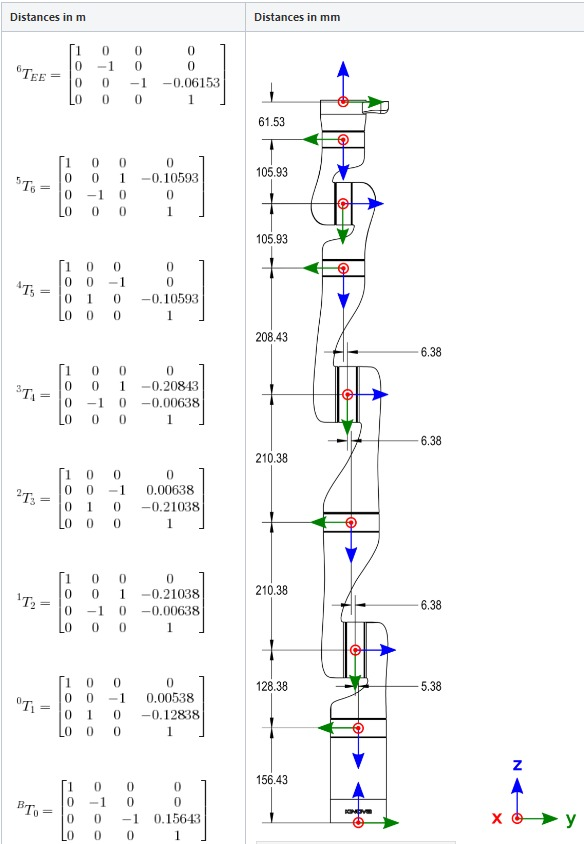
<br>
**Figure 3: Elementary Transforms (ET) of 7DOF Kinova Robot Arm**


Figure 4 shows how the translational and rotational parts of the ETs look. The Elementary Transforms that were seen in Figure 3 are the result of multiplying all the ETs together for a specific frame. These figures were provided by the example GitHub Repository referenced in the ReadMe File. η is just a placeholder variable, it will be 'a' for translation in x, it will be 'b' for translation in y, it will be 'c' for translation in z, it will be α for rotation in x, β for rotation in y, and γ for rotation in z.


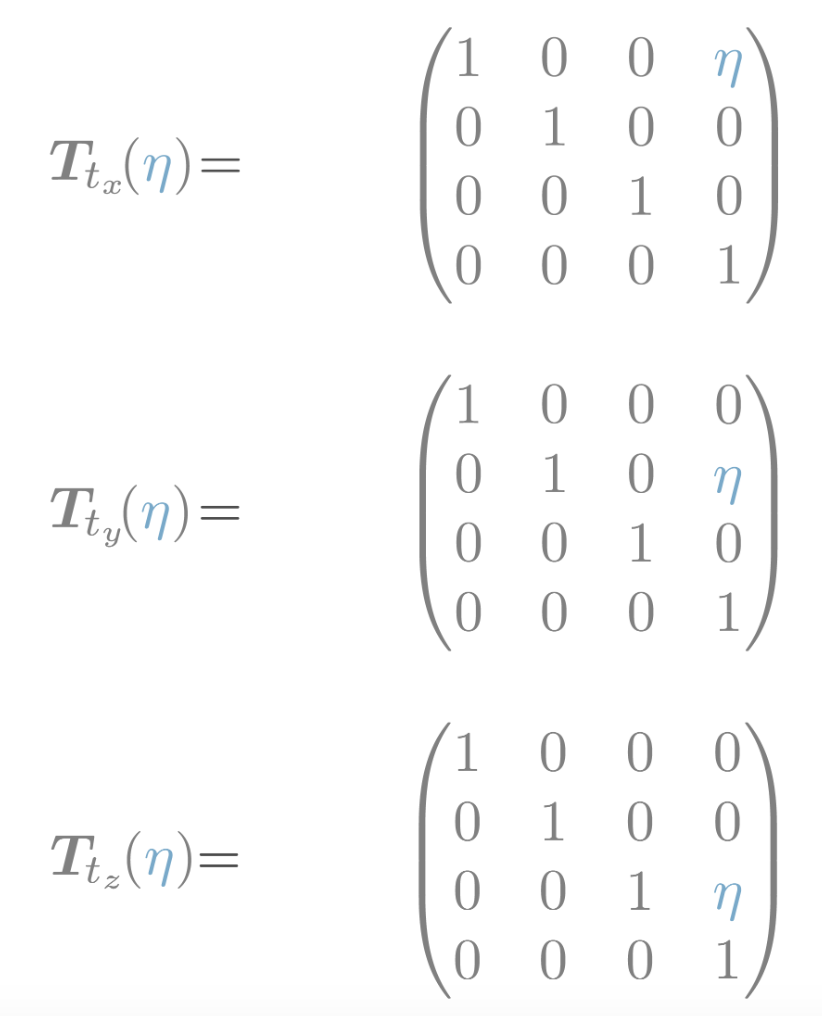
<br>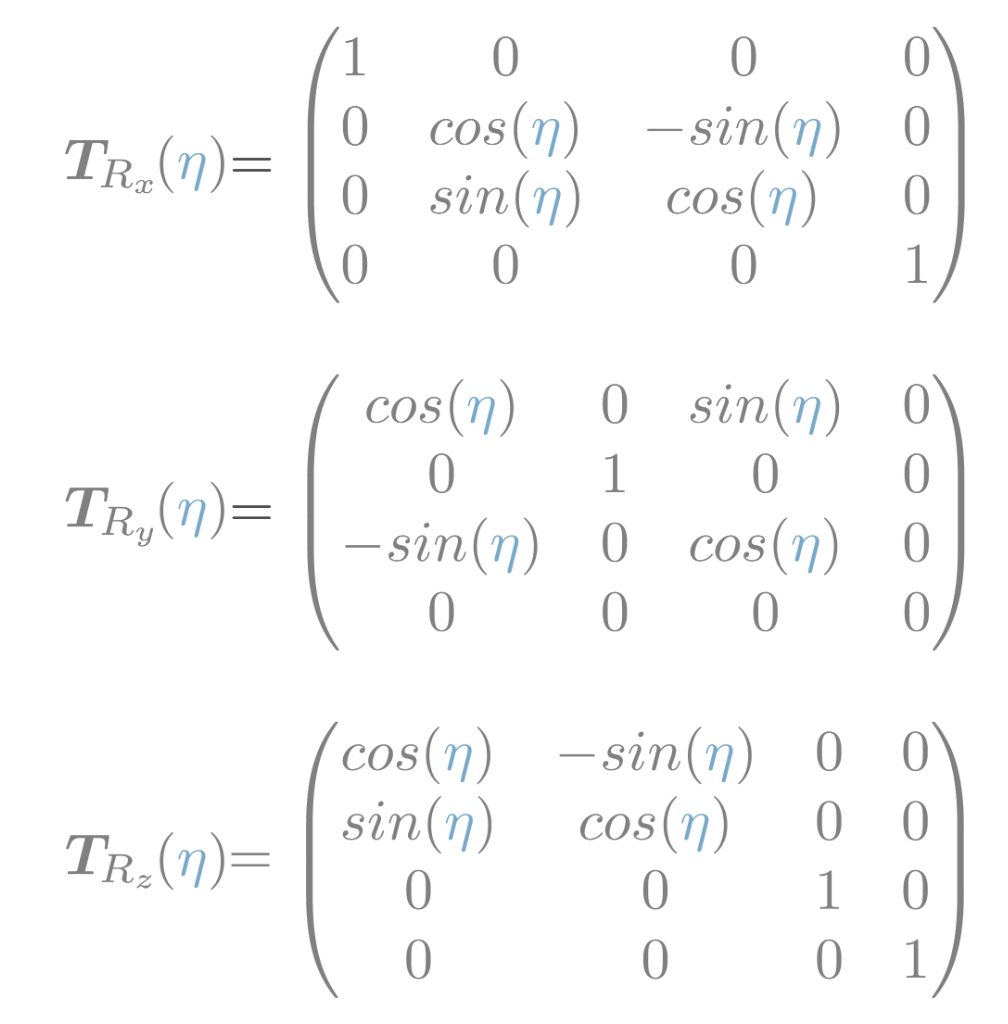
Figure 4: Translational Elementary Transform Matrix Equations

In [ ]:
# These three functions are used for the rotation matrices and match the ones discussed prior

# This defines the function Rx
# This is used when we are rotating about the x-axis
def Rx(theta):
    Rx_matrix = np.array([
        [1, 0, 0, 0],
        [0, np.cos(theta), -np.sin(theta), 0],
        [0, np.sin(theta), np.cos(theta), 0],
        [0, 0, 0, 1]
    ])

    return Rx_matrix

# This defines the function Ry
# This is used when we are rotating about the y-axis
# We do not actually need to use this function in our code but it is here just in case
def Ry(theta):
    Ry_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta), 0],
        [0, 1, 0, 0],
        [-np.sin(theta), 0, np.cos(theta), 0],
        [0, 0, 0, 1]
    ])

    return Ry_matrix

# This defines the function Rz
# This is used when we are rotating about the z-axis
def Rz(theta):
    Rz_matrix = np.array([
        [np.cos(theta), -np.sin(theta), 0, 0],
        [np.sin(theta), np.cos(theta), 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

    return Rz_matrix

# This defines the function T
# This function combines all the individual translation matrices into a singular function
def T(dx, dy, dz):
    T_matrix = np.array([
        [1, 0, 0, dx],
        [0, 1, 0, dy],
        [0, 0, 1, dz],
        [0, 0, 0, 1]
    ])

    return T_matrix


## 1.4 The Homogeneous Matrix
Individually, the ETs are useful to relate the motion of one joint to the next but this is not very helpful in the case of a 7 DOF robotic arm. It is difficult to use the Elementary Transforms individually on their own but, when combined they can provide us with a singular matrix capable of directly relating every movement of the end-effector in base coordinates. In the case of pick and place tasks, it is infinitely easier to complete tasks when we know exactly how the gripper moves relative to a stationary base frame rather than the previous joint. This is where the Homogenous Matrix comes into play. The Homogeneous Matrix relates the position of the end effector directly to the stationary reference frame. The easiest way to create the Homogenous Matrix is by multiplying all of the Elementary Transformation Matrices together in sequential order. Below is how we get the Transformation Matrix that relates each frame to the next in terms of the ETs.

<sup>0</sup>T<sub>1</sub> = E<sub>1</sub> * E<sub>2</sub> * E<sub>3</sub>
<br>
<sup>1</sup>T<sub>2</sub> = E<sub>4</sub> * E<sub>5</sub> * E<sub>6</sub> * E<sub>7</sub>
<br>
<sup>2</sup>T<sub>3</sub> = E<sub>8</sub> * E<sub>9</sub> * E<sub>10</sub> * E<sub>11</sub>
<br>
<sup>3</sup>T<sub>4</sub> = E<sub>12</sub> * E<sub>13</sub> * E<sub>14</sub> * E<sub>15</sub>
<br>
<sup>4</sup>T<sub>5</sub> = E<sub>16</sub> * E<sub>17</sub> * E<sub>18</sub> * E<sub>19</sub>
<br>
<sup>5</sup>T<sub>6</sub> = E<sub>20</sub> * E<sub>21</sub> * E<sub>22</sub>
<br>
<sup>6</sup>T<sub>7</sub> = E<sub>23</sub> * E<sub>24</sub> * E<sub>25</sub>
<br>
<sup>7</sup>T<sub>8</sub> = E<sub>26</sub> * E<sub>27</sub>

For these equations, the letter 'E' represents an Elementary Transform. The translations in z and y are due to the offsets between the joints. The rotations about the x-axis allow the z-axis orientation to change so that the joint rotates about the z-axis. The rotations about the z-axis are simply variables 'q' because this rotation is due to the rotation of the joint which can be any number.

Each of these transforms can be seen below.

E<sub>1</sub> = T<sub>t<sub>z</sub></sub>(0.15643)
<br>
E<sub>2</sub> = T<sub>R<sub>x</sub></sub>(π/2)
<br>
E<sub>3</sub> = T<sub>R<sub>z</sub></sub>(q<sub>1</sub>)
<br>

E<sub>4</sub> = T<sub>t<sub>z</sub></sub>(-0.12838)
<br>
E<sub>5</sub> = T<sub>t<sub>y</sub></sub>(0.00538)
<br>
E<sub>6</sub> = T<sub>R<sub>x</sub></sub>(π/2)
<br>

E<sub>7</sub> = T<sub>R<sub>z</sub></sub>(q<sub>2</sub>)
<br>

E<sub>8</sub> = T<sub>t<sub>z</sub></sub>(-0.00638)
<br>
E<sub>9</sub> = T<sub>t<sub>y</sub></sub>(-0.21038)
<br>
E<sub>10</sub> = T<sub>R<sub>x</sub></sub>(-π/2)
<br>
E<sub>11</sub> = T<sub>R<sub>z</sub></sub>(q<sub>3</sub>)
<br>

E<sub>12</sub> = T<sub>t<sub>z</sub></sub>(-0.21038)
<br>
E<sub>13</sub> = T<sub>t<sub>y</sub></sub>(0.00638)
<br>
E<sub>14</sub> = T<sub>R<sub>x</sub></sub>(π/2)
<br>
E<sub>15</sub> = T<sub>R<sub>z</sub></sub>(q<sub>4</sub>)
<br>

E<sub>16</sub> = T<sub>t<sub>z</sub></sub>(-0.00638)
<br>
E<sub>17</sub> = T<sub>t<sub>y</sub></sub>(-0.20843)
<br>
E<sub>18</sub> = T<sub>R<sub>x</sub></sub>(-π/2)
<br>
E<sub>19</sub> = T<sub>R<sub>z</sub></sub>(q<sub>5</sub>)
<br>

E<sub>20</sub> = T<sub>t<sub>z</sub></sub>(-0.10593)
<br>
E<sub>21</sub> = T<sub>R<sub>x</sub></sub>(-π/2)
<br>
E<sub>22</sub> = T<sub>R<sub>z</sub></sub>(q<sub>6</sub>)
<br>

E<sub>23</sub> = T<sub>t<sub>y</sub></sub>(-0.10593)
<br>
E<sub>24</sub> = T<sub>R<sub>x</sub></sub>(-π/2)
<br>
E<sub>25</sub> = T<sub>R<sub>z</sub></sub>(q<sub>7</sub>)
<br>

E<sub>26</sub> = T<sub>t<sub>y</sub></sub>(-0.06153)
<br>
E<sub>27</sub> = T<sub>R<sub>x</sub></sub>(π)
<br>


In [ ]:
# This function is used to create the Homogenous Transformation Matrix
# Recall, this matrix will relate the position of the base frame to the end-effector

def fk(q_values):
  # These 7 q's correspond to joint angles. Specifically the roation about the z-axis
  # q1 is the roation about the z-axis for joint 1, then q2 is for joint 2, and so on
  # These will constantly be changing because the z-axis is the axis that the joints rotate about.
  # And thus, the values will depend on the desired end-effector pose
    q1 = q_values[0];
    q2 = q_values[1];
    q3 = q_values[2];
    q4 = q_values[3];
    q5 = q_values[4];
    q6 = q_values[5];
    q7 = q_values[6];


# These are the resulting Elementary Transforms that occur at each joint.
# They have been broken down to individual blocks. Each block is essentially an Elementary Transform Sequence.
# The relationship between joint 1 and 2 explains what each term means

# These are the ET's from the base to joint 1
    E1 = T(0, 0, 0.15643)
    E2 = Rx(np.pi)
    E3 = Rz(q1)

# These are the ET's from joint 1 to joint 2
# E4 is telling us that there is an offset in the z-direction
# E5 is telling us that there is an offset in the y-direction
# E6 is telling us that we must rotate the z-axis by pi/2 about the x-axis so that the joint will rotate about the z-axis
# E7 is telling us how much the joint has roatated and is measured about the z-axis
    E4 = T(0, 0, -0.12838)
    E5 = T(0, 0.00538, 0)
    E6 = Rx(np.pi/2)
    E7 = Rz(q2)

# These are the ET's from joint 2 to joint 3
    E8 = T(0, 0, -0.00638)
    E9 = T(0, -0.21038, 0)
    E10 = Rx(-np.pi/2)
    E11 = Rz(q3)

# These are the ET's from joint 3 to joint 4
    E12 = T(0, 0, -0.21038)
    E13 = T(0, 0.00638, 0)
    E14 = Rx(np.pi/2)
    E15 = Rz(q4)

# These are the ET's from joint 4 to joint 5
    E16 = T(0, 0, -0.00638)
    E17 = T(0, -0.20843, 0)
    E18 = Rx(-np.pi/2)
    E19 = Rz(q5)

# These are the ET's from joint 5 to joint 6
    E20 = T(0, 0, -0.10593)
    E21 = Rx(np.pi/2)
    E22 = Rz(q6)

# These are the ET's from joint 6 to joint 7
    E23 = T(0, -0.10593, 0)
    E24 = Rx(-np.pi/2)
    E25 = Rz(q7)

# These are the ET's from joint 7 to the end effector
    E26 = T(0, 0, -0.06153)
    E27 = Rx(np.pi)

# This part is comuting the dot produce of the Elementary Transforms
# Multiplying all of these together in sequencial order will give the Homogenous Matrix
    term1 = np.dot(E1, E2)
    term2 = np.dot(term1, E3)
    term3 = np.dot(term2, E4)
    term4 = np.dot(term3, E5)
    term5 = np.dot(term4, E6)
    term6 = np.dot(term5, E7)
    term7 = np.dot(term6, E8)
    term8 = np.dot(term7, E9)
    term9 = np.dot(term8, E10)
    term10 = np.dot(term9, E11)
    term11 = np.dot(term10, E12)
    term12 = np.dot(term11, E13)
    term13 = np.dot(term12, E14)
    term14 = np.dot(term13, E15)
    term15 = np.dot(term14, E16)
    term16 = np.dot(term15, E17)
    term17 = np.dot(term16, E18)
    term18 = np.dot(term17, E19)
    term19 = np.dot(term18, E20)
    term20 = np.dot(term19, E21)
    term21 = np.dot(term20, E22)
    term22 = np.dot(term21, E23)
    term23 = np.dot(term22, E24)
    term24 = np.dot(term23, E25)
    term25 = np.dot(term24, E26)

  # This is the Homogenous Matrix
  # Recall, that the Homogenous Matrix directly relates the position of the end-effector with respect to the base
    HTM = np.dot(term25, E27)

  # The function then returns the Homogenous Matrix after rounding all values to 13 decimals
    return round_to_zero(HTM,1e-13)

# 1.5 Examples

After reviewing the above, try these examples to become familiar with position kinematics and visually see what the functions do to the matrices.

In [ ]:
#Example 1: Rotations about the x axis

# Define the angle of rotation (in radians)
theta = np.pi/6  # 45 degrees

Rx_matrix = Rx(theta)
Rx_matrix_rounded = np.round(Rx_matrix, decimals=2) #np.round ensures that the deciamls are nicely rounded for you to visualize the rotation better.

print(Rx_matrix_rounded) #displays the rounded rotation matrix, to 2 decimal places, around the x-axis


[[ 1.    0.    0.    0.  ]
 [ 0.    0.87 -0.5   0.  ]
 [ 0.    0.5   0.87  0.  ]
 [ 0.    0.    0.    1.  ]]


In [ ]:
#Example 1 Practice:try and apply the code above with roation around the x axis, and see what happens similary to the y axis and z-axis

  #Type code here#
theta = np.pi/6  #

Ry_matrix = Ry(theta)
Ry_matrix_rounded = np.round(Ry_matrix, decimals=2) #np.round ensures that the deciamls are nicely rounded for you to visualize the rotation better.

print(Ry_matrix_rounded) #displays the rounded rotation matrix, to 2 decimal places, around the x-axis

[[ 0.87  0.    0.5   0.  ]
 [ 0.    1.    0.    0.  ]
 [-0.5   0.    0.87  0.  ]
 [ 0.    0.    0.    1.  ]]


In [ ]:
#Example 2: Creation of a Homogenous matrix